In [2]:
TRAIN_DATA_DIR = "chest_xray/train"
VAL_DATA_DIR = "chest_xray/val"
TEST_DATA_DIR = "chest_xray/test"

In [3]:
# Define data directories for all sets
data_dirs = {
    'train': TRAIN_DATA_DIR,
    'val': VAL_DATA_DIR,
    'test': TEST_DATA_DIR
}

In [4]:
import os

# Function to analyze dataset distribution
def print_dataset_stats(data_dirs):
    total_normal = 0
    total_pneumonia = 0
    
    print("Dataset Distribution:")
    print("-" * 50)
    
    for dataset_type, dir_path in data_dirs.items():
        normal_path = os.path.join(dir_path, 'NORMAL')
        pneumonia_path = os.path.join(dir_path, 'PNEUMONIA')
        
        normal_count = len(os.listdir(normal_path))
        pneumonia_count = len(os.listdir(pneumonia_path))
        
        total_normal += normal_count
        total_pneumonia += pneumonia_count
        
        print(f"{dataset_type.capitalize()} set:")
        print(f"  Normal X-Rays: {normal_count}")
        print(f"  Pneumonia X-Rays: {pneumonia_count}")
        print(f"  Ratio (Pneumonia/Normal): {pneumonia_count/normal_count:.2f}")
        print()
    
    print("Overall Statistics:")
    print(f"Total Normal cases: {total_normal}")
    print(f"Total Pneumonia cases: {total_pneumonia}")
    print(f"Total images: {total_normal + total_pneumonia}")

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_sample_images(data_dirs, samples_per_class=5):
    for dataset_type, dir_path in data_dirs.items():
        normal_path = os.path.join(dir_path, 'NORMAL')
        pneumonia_path = os.path.join(dir_path, 'PNEUMONIA')
        
        normal_samples = np.random.choice(os.listdir(normal_path), samples_per_class, replace=False)
        pneumonia_samples = np.random.choice(os.listdir(pneumonia_path), samples_per_class, replace=False)
        
        fig, axes = plt.subplots(2, samples_per_class, figsize=(20, 8))
        fig.suptitle(f'Sample Images from {dataset_type.capitalize()} Set', fontsize=16)
        
        for idx, (norm_img, pneu_img) in enumerate(zip(normal_samples, pneumonia_samples)):
            # Plot normal images
            norm_img_path = os.path.join(normal_path, norm_img)
            img = Image.open(norm_img_path)
            axes[0, idx].imshow(img, cmap='gray')
            axes[0, idx].axis('off')
            axes[0, idx].set_title('Normal')
            
            # Plot pneumonia images
            pneu_img_path = os.path.join(pneumonia_path, pneu_img)
            img = Image.open(pneu_img_path)
            axes[1, idx].imshow(img, cmap='gray')
            axes[1, idx].axis('off')
            axes[1, idx].set_title('Pneumonia')
        
        plt.tight_layout()
        plt.show()

Dataset Distribution:
--------------------------------------------------
Train set:
  Normal X-Rays: 1341
  Pneumonia X-Rays: 3876
  Ratio (Pneumonia/Normal): 2.89

Val set:
  Normal X-Rays: 8
  Pneumonia X-Rays: 8
  Ratio (Pneumonia/Normal): 1.00

Test set:
  Normal X-Rays: 234
  Pneumonia X-Rays: 390
  Ratio (Pneumonia/Normal): 1.67

Overall Statistics:
Total Normal cases: 1583
Total Pneumonia cases: 4274
Total images: 5857


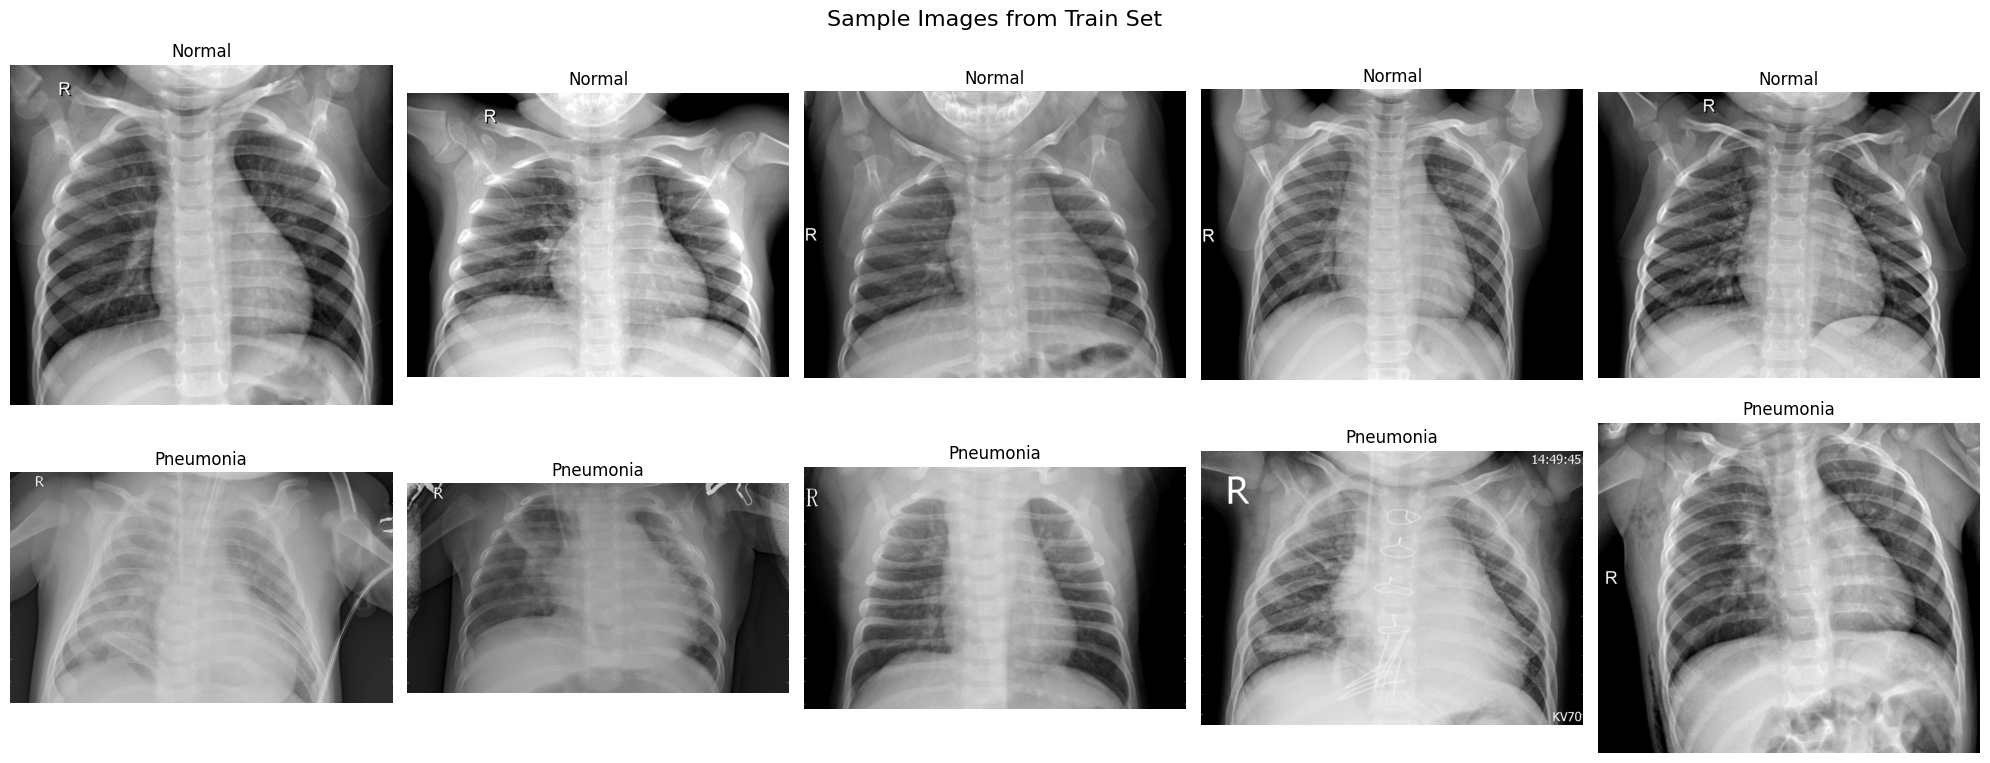

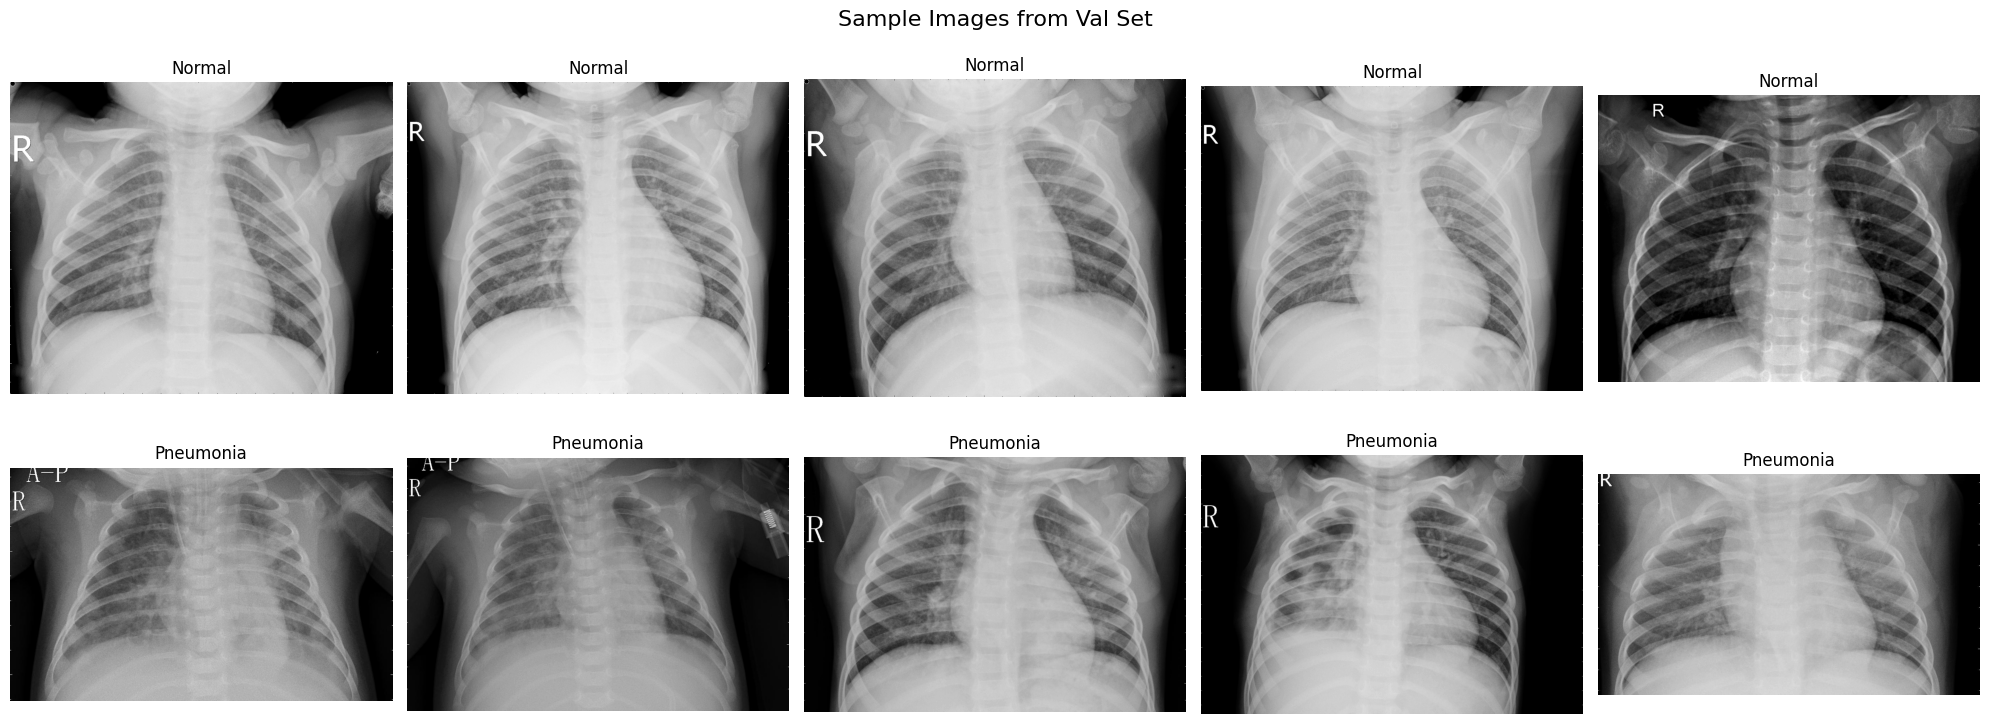

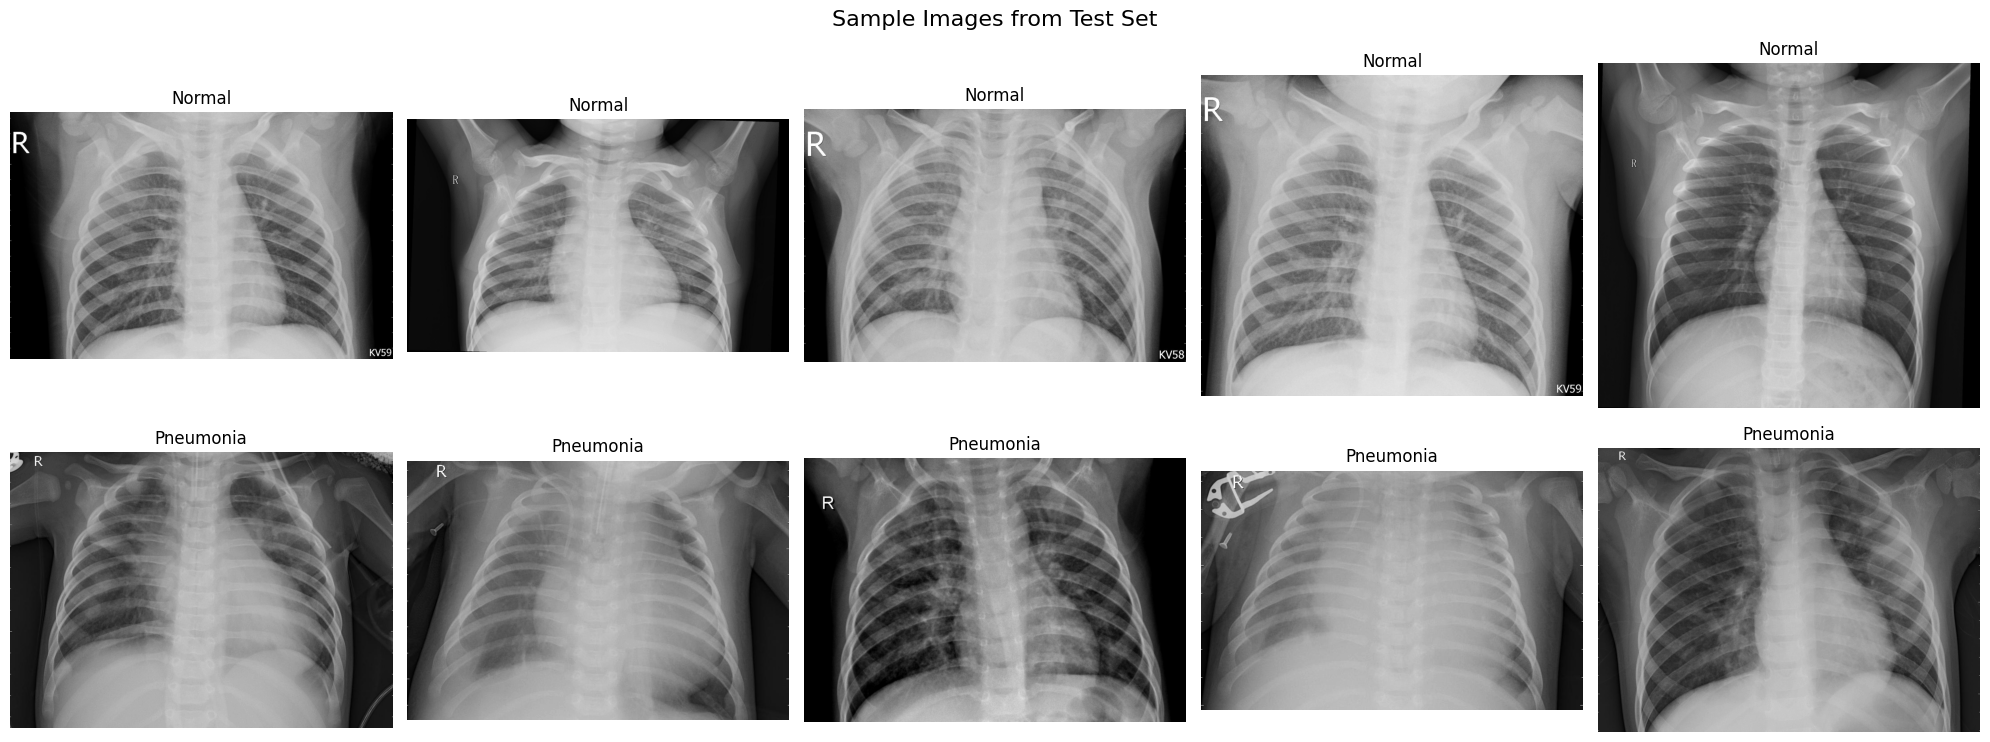

In [6]:
print_dataset_stats(data_dirs)
plot_sample_images(data_dirs)

In [7]:
# Image parameters
IMG_SIZE = (128, 128)
IMG_CHANNELS = 3
BATCH_SIZE = 32

In [8]:
import tensorflow as tf

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Normalization()
])

2024-11-14 12:44:26.017605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 12:44:30.852507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-14 12:44:30.852559: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Function to prepare datasets
def prepare_dataset(directory, subset=None):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        validation_split=0.2 if subset in ['training', 'validation'] else None,
        subset=subset,
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='binary',
        shuffle=True if subset in ['training', 'validation'] else False
    )

In [10]:
# Create datasets
train_dataset = prepare_dataset(data_dirs['train'], subset='training')
val_dataset = prepare_dataset(data_dirs['train'], subset='validation')
test_dataset = prepare_dataset(data_dirs['test'])

# Adapt the normalization layer to the training data
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(train_dataset.map(lambda x, y: x))

# Apply data augmentation and normalization
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
val_dataset = val_dataset.map(lambda x, y: (data_augmentation(x, training=False), y))
test_dataset = test_dataset.map(lambda x, y: (data_augmentation(x, training=False), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


2024-11-14 12:44:33.094255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4173]
	 [[{{node Placeholder/_4}}]]
2024-11-14 12:44:33.094644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4173]
	 [[{{node Placeholder/_0}}]]
2024-11-14 12:44:33.230959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-14 12:44:33.267637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [11]:
from sklearn.utils import class_weight
import numpy as np

# Assuming you have access to all labels in the training set
y_train = np.concatenate([y for x, y in train_dataset], axis=0).flatten()
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

2024-11-14 12:44:44.946063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype float and shape [1,1,1,3]
	 [[{{node Placeholder/_24}}]]
2024-11-14 12:44:44.946613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype float and shape [1,1,1,3]
	 [[{{node Placeholder/_24}}]]
2024-11-14 12:44:45.005250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [12]:
class_weights

{0: 1.8831227436823104, 1: 0.6807504078303426}

In [24]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

def initialize_improved_model(name: str) -> Model:
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (IMG_CHANNELS,))
    base_model.trainable = False  # Freeze the base model

    inputs = layers.Input(shape=IMG_SIZE + (IMG_CHANNELS,), name='input_layer')
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Activation('relu', name='relu1')(x)
    x = layers.Dropout(0.5, name='dropout1')(x)

    x = layers.Dense(256, name='fc1')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Activation('relu', name='relu2')(x)
    x = layers.Dropout(0.5, name='dropout2')(x)

    x = layers.Dense(128, name='fc2')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Activation('relu', name='relu3')(x)
    x = layers.Dropout(0.5, name='dropout3')(x)

    outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [25]:
model = initialize_improved_model(name="basemodel")
model.summary()

Model: "basemodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 bn1 (BatchNormalization)    (None, 2048)              8192      
                                                                 
 relu1 (Activation)          (None, 2048)              0         
                                                                 
 dropout1 (Dropout)          (None, 2048)              0         
                                                         

In [26]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1. - y_pred)
        return -tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt))
    return focal_loss_fixed

In [16]:
def compile_model(model):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss=focal_loss(),metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_baseline = initialize_improved_model(name="baseline")
compiled_model = compile_model(model_baseline)
callbacks = [EarlyStopping(patience=5, monitor='val_auc', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor=0.5, verbose=1),
            ModelCheckpoint("xray_model.keras", save_best_only=True)]

In [29]:
history_baseline = compiled_model.fit(train_dataset,
                                      batch_size=BATCH_SIZE,
                                      epochs=20,
                                      validation_data=val_dataset,
                                      shuffle=True,
                                      callbacks=callbacks,
                                      class_weight=class_weights
                                      )

2024-11-14 12:58:02.781676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_23' with dtype float and shape [1,1,1,3]
	 [[{{node Placeholder/_23}}]]
2024-11-14 12:58:02.782417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4173]
	 [[{{node Placeholder/_4}}]]
2024-11-14 12:58:02.853947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-14 12:58:02.976573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.

Epoch 1/20


2024-11-14 12:58:07.066031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-14 12:58:07.529724: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


131/131 [==============================] - ETA: 0s - loss: 0.0914 - binary_accuracy: 0.5584 - auc: 0.5996

2024-11-14 12:58:32.821887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 37s 215ms/step - loss: 0.0914 - binary_accuracy: 0.5584 - auc: 0.5996 - val_loss: 0.0331 - val_binary_accuracy: 0.7766 - val_auc: 0.8096 - lr: 1.0000e-04
Epoch 2/20


2024-11-14 12:58:39.809143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 34s 258ms/step - loss: 0.0506 - binary_accuracy: 0.7165 - auc: 0.7219 - val_loss: 0.0297 - val_binary_accuracy: 0.7795 - val_auc: 0.8745 - lr: 1.0000e-04


2024-11-14 12:59:14.313685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 3/20
131/131 [==============================] - 43s 322ms/step - loss: 0.0466 - binary_accuracy: 0.7273 - auc: 0.7296 - val_loss: 0.0268 - val_binary_accuracy: 0.7824 - val_auc: 0.8930 - lr: 1.0000e-04


2024-11-14 12:59:57.884358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 4/20
131/131 [==============================] - 43s 317ms/step - loss: 0.0417 - binary_accuracy: 0.7599 - auc: 0.7691 - val_loss: 0.0234 - val_binary_accuracy: 0.8341 - val_auc: 0.9147 - lr: 1.0000e-04


2024-11-14 13:00:41.183548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 5/20
131/131 [==============================] - 43s 319ms/step - loss: 0.0391 - binary_accuracy: 0.7661 - auc: 0.7901 - val_loss: 0.0226 - val_binary_accuracy: 0.8600 - val_auc: 0.9246 - lr: 1.0000e-04


2024-11-14 13:01:24.314242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 6/20
131/131 [==============================] - 41s 302ms/step - loss: 0.0375 - binary_accuracy: 0.7676 - auc: 0.7932 - val_loss: 0.0245 - val_binary_accuracy: 0.8533 - val_auc: 0.9387 - lr: 1.0000e-04


2024-11-14 13:02:05.856244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 7/20
131/131 [==============================] - 42s 315ms/step - loss: 0.0359 - binary_accuracy: 0.7759 - auc: 0.8076 - val_loss: 0.0275 - val_binary_accuracy: 0.8092 - val_auc: 0.9392 - lr: 1.0000e-04


2024-11-14 13:02:48.511551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 8/20
131/131 [==============================] - ETA: 0s - loss: 0.0349 - binary_accuracy: 0.7815 - auc: 0.8141
Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
131/131 [==============================] - 46s 341ms/step - loss: 0.0349 - binary_accuracy: 0.7815 - auc: 0.8141 - val_loss: 0.0276 - val_binary_accuracy: 0.8102 - val_auc: 0.9431 - lr: 1.0000e-04


2024-11-14 13:03:34.678328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 9/20
131/131 [==============================] - 43s 318ms/step - loss: 0.0338 - binary_accuracy: 0.7865 - auc: 0.8257 - val_loss: 0.0268 - val_binary_accuracy: 0.8150 - val_auc: 0.9429 - lr: 5.0000e-05


2024-11-14 13:04:17.903517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 10/20
131/131 [==============================] - 43s 316ms/step - loss: 0.0331 - binary_accuracy: 0.7884 - auc: 0.8305 - val_loss: 0.0255 - val_binary_accuracy: 0.8274 - val_auc: 0.9450 - lr: 5.0000e-05


2024-11-14 13:05:00.689347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 11/20
131/131 [==============================] - ETA: 0s - loss: 0.0327 - binary_accuracy: 0.7970 - auc: 0.8357
Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
131/131 [==============================] - 49s 363ms/step - loss: 0.0327 - binary_accuracy: 0.7970 - auc: 0.8357 - val_loss: 0.0249 - val_binary_accuracy: 0.8284 - val_auc: 0.9479 - lr: 5.0000e-05


2024-11-14 13:05:49.821278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 12/20
131/131 [==============================] - 44s 329ms/step - loss: 0.0322 - binary_accuracy: 0.7985 - auc: 0.8395 - val_loss: 0.0250 - val_binary_accuracy: 0.8284 - val_auc: 0.9476 - lr: 2.5000e-05


2024-11-14 13:06:34.607695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 13/20
131/131 [==============================] - 43s 322ms/step - loss: 0.0321 - binary_accuracy: 0.7910 - auc: 0.8343 - val_loss: 0.0246 - val_binary_accuracy: 0.8332 - val_auc: 0.9477 - lr: 2.5000e-05


2024-11-14 13:07:18.157215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 14/20
131/131 [==============================] - ETA: 0s - loss: 0.0302 - binary_accuracy: 0.7913 - auc: 0.8449
Epoch 14: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
131/131 [==============================] - 46s 343ms/step - loss: 0.0302 - binary_accuracy: 0.7913 - auc: 0.8449 - val_loss: 0.0258 - val_binary_accuracy: 0.8178 - val_auc: 0.9480 - lr: 2.5000e-05


2024-11-14 13:08:04.802014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 15/20
131/131 [==============================] - 44s 322ms/step - loss: 0.0317 - binary_accuracy: 0.7932 - auc: 0.8363 - val_loss: 0.0254 - val_binary_accuracy: 0.8226 - val_auc: 0.9482 - lr: 1.2500e-05


2024-11-14 13:08:48.662493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 16/20
131/131 [==============================] - 42s 312ms/step - loss: 0.0312 - binary_accuracy: 0.7915 - auc: 0.8431 - val_loss: 0.0251 - val_binary_accuracy: 0.8245 - val_auc: 0.9486 - lr: 1.2500e-05


2024-11-14 13:09:30.897496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 17/20
131/131 [==============================] - ETA: 0s - loss: 0.0302 - binary_accuracy: 0.8037 - auc: 0.8506
Epoch 17: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
131/131 [==============================] - 47s 345ms/step - loss: 0.0302 - binary_accuracy: 0.8037 - auc: 0.8506 - val_loss: 0.0251 - val_binary_accuracy: 0.8284 - val_auc: 0.9492 - lr: 1.2500e-05


2024-11-14 13:10:18.165399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 18/20
131/131 [==============================] - 45s 335ms/step - loss: 0.0311 - binary_accuracy: 0.7958 - auc: 0.8381 - val_loss: 0.0246 - val_binary_accuracy: 0.8284 - val_auc: 0.9495 - lr: 6.2500e-06


2024-11-14 13:11:03.566139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 19/20
131/131 [==============================] - 44s 330ms/step - loss: 0.0297 - binary_accuracy: 0.8023 - auc: 0.8518 - val_loss: 0.0254 - val_binary_accuracy: 0.8198 - val_auc: 0.9499 - lr: 6.2500e-06


2024-11-14 13:11:48.288232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 20/20
131/131 [==============================] - ETA: 0s - loss: 0.0309 - binary_accuracy: 0.7954 - auc: 0.8438
Epoch 20: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
131/131 [==============================] - 44s 328ms/step - loss: 0.0309 - binary_accuracy: 0.7954 - auc: 0.8438 - val_loss: 0.0249 - val_binary_accuracy: 0.8255 - val_auc: 0.9503 - lr: 6.2500e-06


In [35]:
scores = model_baseline.evaluate(val_dataset)
scores


33/33 [==============================] - 5s 95ms/step - loss: 0.0249 - binary_accuracy: 0.8255 - auc: 0.9503


[0.02493814192712307, 0.8255033493041992, 0.9502755403518677]

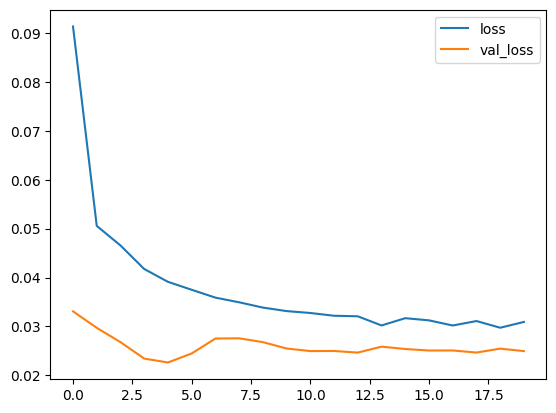

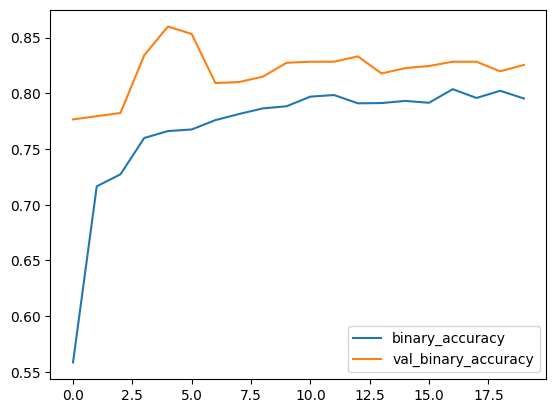

In [31]:
import pandas as pd
history_frame = pd.DataFrame(history_baseline.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [32]:
# Function to collect true labels and predictions
def get_predictions(model, dataset):
    true_labels = []
    predictions = []
    
    for batch in dataset:
        images, labels = batch
        preds = model.predict(images)
        preds = np.squeeze(preds)
        preds = (preds > 0.5).astype(int)
        
        true_labels.extend(labels.numpy())
        predictions.extend(preds)
    
    return np.array(true_labels), np.array(predictions)

# Get true labels and predictions
true_labels, predictions = get_predictions(model_baseline, test_dataset)

2024-11-14 13:13:00.409182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 76ms/step


2024-11-14 13:13:05.794318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


In [33]:
from sklearn.metrics import f1_score, classification_report
# Calculate F1 score
f1 = f1_score(true_labels, predictions)
print(f"F1 Score: {f1:.4f}")

# Optionally, print a detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['Normal', 'Pneumonia']))

F1 Score: 0.8136

Classification Report:
              precision    recall  f1-score   support

      Normal       0.68      0.74      0.71       234
   Pneumonia       0.83      0.79      0.81       390

    accuracy                           0.77       624
   macro avg       0.76      0.76      0.76       624
weighted avg       0.78      0.77      0.77       624



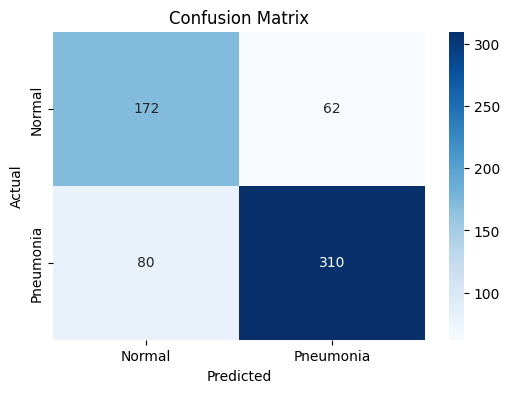

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()